In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-23 03:17:19.062848: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 03:17:19.088816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-23 03:17:20.221109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.226691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.226868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        best_params = opt_manager.get_best_params()
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict(test, return_targets=True)
        targets = data_formatter.format_predictions(output_map["targets"])
        p50_forecast = data_formatter.format_predictions(output_map["p50"])
        p90_forecast = data_formatter.format_predictions(output_map["p90"])

        def extract_numerical_data(data):
            """Strips out forecast time and identifier columns."""
            return data[[
                col for col in data.columns
                if col not in {"forecast_time", "identifier"}
            ]]

        p50_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p50_forecast), 0.5)
        p90_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p90_forecast), 0.9)

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    print()
    print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
        p50_loss.mean(), p90_loss.mean()))
    
    return output_map



In [3]:
dataset_name = 'crypto_minute'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()

# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

2023-11-23 03:17:20.265422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.265599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.265700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Using output folder .


2023-11-23 03:17:20.633038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.633187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:17:20.633304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_minute ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.5
hidden_layer_size: 10
learning_rate: 0.01
minibatch_size: 64
max_gradient_norm: 100.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_minute/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.5
# hidden_layer_size = 10
# learning_rate = 0.01
# max_gradient_norm = 100.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_minute/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 61
# num_encoder_steps = 60
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('symbol_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('ts', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('row_id', <DataTypes.REAL

2023-11-23 03:17:21.012291: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:21.014346: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-23 03:17:21.212882: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/bias/Assign' id:346 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/bias, TemporalFusionTransformer/time_distributed_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:21.219065: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_1' id:359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-23 03:17:21.414536: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:633 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 4>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:21.419939: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:634 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutatio

2023-11-23 03:17:21.994571: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:22.014899: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_17/kernel/Assign' id:1818 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_17/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_17/kernel, TemporalFusionTransformer/time_distributed_

2023-11-23 03:17:22.717614: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_34/kernel/Assign' id:2621 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_34/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_34/kernel, TemporalFusionTransformer/time_distributed_34/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:22.758137: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_28/stack_1' id:2785 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_28/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-23 03:17:23.682307: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_56/kernel/Assign' id:3654 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_56/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_56/kernel, TemporalFusionTransformer/time_distributed_56/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:23.737218: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_33/stack_1' id:3750 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_33/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-23 03:17:24.902052: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_75/kernel/Assign' id:4581 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_75/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_75/kernel, TemporalFusionTransformer/time_distributed_75/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:24.972898: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:4715 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-23 03:17:26.390302: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_4/dim' id:5358 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_4/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:26.458349: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_24/gamma/Assign' id:5509 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_24/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_24/gamma, TemporalFusionTransformer/layer_norma

2023-11-23 03:17:27.950440: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:6239 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:28.024110: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_42/stack' id:6233 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_42/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 61, 17)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 17)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_27[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 61, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 61, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
                                                                    ]']                           
          

                                                                     'time_distributed_13[0][0]', 
                                                                     'time_distributed_14[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 10, 1)]          0         ['time_distributed_15[0][0]'] 
 Transformer/stack_3 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
          

 26 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 28 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

2023-11-23 03:17:28.889341: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:6872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


                                                                    0]']                          
                                                                                                  
 time_distributed_26 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_25[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_30 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_26[0][
                                                                    0]']                          
                                                                                                  
 time_dist

 activation_14 (Activation)  (None, 60, 10)               0         ['time_distributed_42[0][0]'] 
                                                                                                  
 activation_15 (Activation)  (None, 60, 10)               0         ['time_distributed_46[0][0]'] 
                                                                                                  
 activation_16 (Activation)  (None, 60, 10)               0         ['time_distributed_50[0][0]'] 
                                                                                                  
 activation_17 (Activation)  (None, 60, 10)               0         ['time_distributed_54[0][0]'] 
                                                                                                  
 activation_18 (Activation)  (None, 60, 10)               0         ['time_distributed_58[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 time_distributed_20 (TimeD  (None, 60, 16)               176       ['dropout_6[0][0]']           
 istributed)                                                                                      
                                                                                                  
 time_distributed_21 (TimeD  (None, 60, 16)               176       ['dropout_6[0][0]']           
 istributed)                                                                                      
                                                                                                  
 dropout_7 (Dropout)         (None, 60, 10)               0         ['time_distributed_23[0][0]'] 
                                                                                                  
 dropout_8 (Dropout)         (None, 60, 10)               0         ['time_distributed_27[0][0]'] 
          

 time_distributed_41 (TimeD  (None, 60, 10)               110       ['dropout_11[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_44 (TimeD  (None, 60, 10)               110       ['dropout_12[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_45 (TimeD  (None, 60, 10)               110       ['dropout_12[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_48 (TimeD  (None, 60, 10)               110       ['dropout_13[0][0]']          
 istribute

                                                                                                  
 multiply_8 (Multiply)       (None, 60, 10)               0         ['time_distributed_24[0][0]', 
                                                                     'time_distributed_25[0][0]'] 
                                                                                                  
 multiply_9 (Multiply)       (None, 60, 10)               0         ['time_distributed_28[0][0]', 
                                                                     'time_distributed_29[0][0]'] 
                                                                                                  
 multiply_10 (Multiply)      (None, 60, 10)               0         ['time_distributed_32[0][0]', 
                                                                     'time_distributed_33[0][0]'] 
                                                                                                  
 multiply_

 add_10 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_27[0][
                                                                    0]',                          
                                                                     'multiply_11[0][0]']         
                                                                                                  
 add_11 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_28[0][
                                                                    0]',                          
                                                                     'multiply_12[0][0]']         
                                                                                                  
 add_12 (A

                                                                                                  
 layer_normalization_9 (Lay  (None, 60, 10)               20        ['add_9[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_10 (La  (None, 60, 10)               20        ['add_10[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_11 (La  (None, 60, 10)               20        ['add_11[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                     'layer_normalization_18[0][0]
                                                                    ',                            
                                                                     'layer_normalization_19[0][0]
                                                                    ',                            
                                                                     'layer_normalization_20[0][0]
                                                                    ',                            
                                                                     'layer_normalization_21[0][0]
                                                                    ',                            
                                                                     'layer_normalization_22[0][0]
                                                                    ']                            
          

 orFlowOpLayer)                                                                                   
                                                                                                  
 dropout_3 (Dropout)         (None, 10)                   0         ['dense_31[0][0]']            
                                                                                                  
 dropout_25 (Dropout)        (None, 61, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_2[0][0]']    
                                                                                                  
 dense_32 (Dense)            (None, 10)                   110       ['dropout_3[0][0]']           
                                                                                                  
 dense_33 (Dense)            (None, 10)                   110       ['dropout_3[0][0]']           
          

                                                                                                  
 tf_op_layer_TemporalFusion  [()]                         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/Shape[0][0]']       
 41 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_26[0][0]
 Transformer/Shape_1 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [()]                         0         ['tf_op_layer_TemporalFusionTr
 Transform

                                                                     'time_distributed_104[0][0]']
                                                                                                  
 add_28 (Add)                (None, 61, 10)               0         ['multiply_30[0][0]',         
                                                                     'layer_normalization_26[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_27 (La  (None, 61, 10)               20        ['add_28[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 time_distributed_105 (Time  (None, 61, 10)               110       ['layer_normalization_27[0][0]
 Distribut

2023-11-23 03:17:32.033807: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_29/beta/Assign' id:6820 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_29/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_29/beta, TemporalFusionTransformer/layer_normalization_29/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 89940 samples, validate on 9940 samples
Epoch 1/100


2023-11-23 03:17:34.927803: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:17:35.456869: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/time_distributed_36/kernel/m/Assign' id:11386 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/time_distributed_36/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTrans

89940/89940 [==============================] - ETA: 0s - loss: 0.0349

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-23 03:18:23.146818: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


89940/89940 [==============================] - 51s 572us/sample - loss: 0.0349 - val_loss: 0.3670
Epoch 2/100
89940/89940 [==============================] - 45s 505us/sample - loss: 0.0152 - val_loss: 0.1864
Epoch 3/100
89940/89940 [==============================] - 45s 504us/sample - loss: 0.0136 - val_loss: 0.2457
Epoch 4/100
89940/89940 [==============================] - 45s 501us/sample - loss: 0.0128 - val_loss: 0.1737
Epoch 5/100
89940/89940 [==============================] - 45s 503us/sample - loss: 0.0128 - val_loss: 0.1336
Epoch 6/100
89940/89940 [==============================] - 45s 504us/sample - loss: 0.0125 - val_loss: 0.1632
Epoch 7/100
89940/89940 [==============================] - 46s 508us/sample - loss: 0.0126 - val_loss: 0.1009
Epoch 8/100
89940/89940 [==============================] - 45s 503us/sample - loss: 0.0122 - val_loss: 0.0632
Epoch 9/100
89940/89940 [==============================] - 46s 507us/sample - loss: 0.0123 - val_loss: 0.0606
Epoch 10/100
89940/899

2023-11-23 03:31:19.925443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:31:19.926585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 03:31:19.926990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-23 03:31:20.142757: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:307 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distributed_6/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:20.149682: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_10/stack_1' id:320 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_10/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-23 03:31:20.363178: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_13/bias/Assign' id:580 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_13/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_13/bias, TemporalFusionTransformer/time_distributed_13/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:20.374814: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_17/stack_1' id:593 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_17/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-23 03:31:21.004315: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:681 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 60 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:21.024624: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_2' id:682 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mu

2023-11-23 03:31:21.690510: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_1' id:2592 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 4>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:21.720221: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_2' id:2593 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutat

2023-11-23 03:31:22.614189: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_52/kernel/Assign' id:3461 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_52/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_52/kernel, TemporalFusionTransformer/time_distributed_52/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:22.669257: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_32/stack_1' id:3557 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_32/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-23 03:31:23.846061: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_72/bias/Assign' id:4431 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_72/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_72/bias, TemporalFusionTransformer/time_distributed_72/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:23.923243: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_1' id:4522 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-23 03:31:25.071574: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_3/dim' id:5118 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_3/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:25.137569: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_87/bias/Assign' id:5170 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_87/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_87/bias, TemporalFusionTransformer/time_distributed_87/bia

2023-11-23 03:31:26.732223: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_100/bias/Assign' id:6099 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_100/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_100/bias, TemporalFusionTransformer/time_distributed_100/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 03:31:26.852940: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/k' id:6243 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/k}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] v

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 61, 17)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 17)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_27[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 61, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 61, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
                                                                    ]']                           
          

                                                                     'time_distributed_13[0][0]', 
                                                                     'time_distributed_14[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 10, 1)]          0         ['time_distributed_15[0][0]'] 
 Transformer/stack_3 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
          

 26 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 28 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_42 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_29[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_46 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_30[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_50 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
          

2023-11-23 03:31:28.340293: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:6872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 time_distributed_66 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_35[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_70 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_36[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_74 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_37[0][
          

                                                                                                  
 time_distributed_39 (TimeD  (None, 60, 10)               110       ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_43 (TimeD  (None, 60, 10)               110       ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_47 (TimeD  (None, 60, 10)               110       ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_dist

 dense_38 (Dense)            (None, 10)                   110       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 dropout_23 (Dropout)        (None, 1, 10)                0         ['time_distributed_89[0][0]'] 
                                                                                                  
 time_distributed_93 (TimeD  (None, 1, 10)                110       ['activation_27[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_16 (TimeD  (None, 60, 16)               2576      ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape[0][0]']     
          

 time_distributed_69 (TimeD  (None, 60, 10)               110       ['dropout_18[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_72 (TimeD  (None, 60, 10)               110       ['dropout_19[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_73 (TimeD  (None, 60, 10)               110       ['dropout_19[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_76 (TimeD  (None, 60, 10)               110       ['dropout_20[0][0]']          
 istribute

                                                                                                  
 multiply_22 (Multiply)      (None, 60, 10)               0         ['time_distributed_80[0][0]', 
                                                                     'time_distributed_81[0][0]'] 
                                                                                                  
 multiply_23 (Multiply)      (None, 60, 10)               0         ['time_distributed_84[0][0]', 
                                                                     'time_distributed_85[0][0]'] 
                                                                                                  
 dense_35 (Dense)            (None, 10)                   110       ['activation_5[0][0]']        
                                                                                                  
 dense_39 (Dense)            (None, 10)                   110       ['activation_6[0][0]']        
          

                                                                    0]',                          
                                                                     'multiply_19[0][0]']         
                                                                                                  
 add_19 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_36[0][
                                                                    0]',                          
                                                                     'multiply_20[0][0]']         
                                                                                                  
 add_20 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_37[0][
          

                                                                                                  
 dense_36 (Dense)            (None, 10)                   110       ['dropout_4[0][0]']           
                                                                                                  
 dense_37 (Dense)            (None, 10)                   110       ['dropout_4[0][0]']           
                                                                                                  
 dense_40 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 dense_41 (Dense)            (None, 10)                   110       ['dropout_5[0][0]']           
                                                                                                  
 layer_normalization_23 (La  (None, 1, 1)                 2         ['add_23[0][0]']              
 yerNormal

 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['multiply_24[0][0]']         
 Transformer/Sum_1 (TensorF                                                                       
 lowOpLayer)                                                                                      
                                                                                                  
 layer_normalization_4 (Lay  (None, 10)                   20        ['add_4[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_5 (Lay  (None, 10)                   20        ['add_5[0][0]']               
 erNormali

 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_3[0][0]'
 Transformer/ExpandDims_5 (                                         ]                             
 TensorFlowOpLayer)                                                                               
                                                                                                  
 time_distributed_98 (TimeD  (None, 61, 10)               110       ['layer_normalization_25[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_99 (TimeD  (None, 1, 10)                100       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/ExpandDims_5[0][0]']
                                                                                                  
 tf_op_lay

 dense_131 (Dense)           (None, 61, 10)               100       ['layer_normalization_26[0][0]
                                                                    ']                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 61, 61)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/Cumsum (Tensor                                         ansformer/eye/diag[0][0]']    
 FlowOpLayer)                                                                                     
                                                                                                  
 lambda (Lambda)             (None, 61, 61)               0         ['dense_130[0][0]',           
                                                                     'dense_131[0][0]']           
                                                                                                  
 lambda_1 

                                                                     'time_distributed_110[0][0]']
                                                                                                  
 add_30 (Add)                (None, 61, 10)               0         ['multiply_32[0][0]',         
                                                                     'layer_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_29 (La  (None, 61, 10)               20        ['add_30[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_29[0][0]
 Transform

2023-11-23 03:31:28.815023: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_111/bias/Assign' id:6918 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_111/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_111/bias, TemporalFusionTransformer/time_distributed_111/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Loading model from ./saved_models/crypto_minute/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/cu_dnnlstm/bias (float32) [80]
[ 0.38179988 -0.01804075 -0.15910609  1.2757598   1.296014    0.18199326
 -0.29164094 -0.49560142  0.06157828  0.6119857  -0.98413044  0.9606294
  0.20232667  1.6289803   0.69914633  0.5744131   1.4278103  -0.5004406
  0.5696623  -0.01681852  0.07572363  0.52033865 -0.43154946 -0.21357019
 -1.5691285  -0.7571951  -0.0398068   0.3452679   0.6676879  -0.08233286
 -1.4590114   1.4666772  -1.4588807  -0.16573721 -2.0031636  -0.29826662
 -1.0639011  -0.40134963 -0.7792884  -2.195849    0.38179988 -0.01804075
 -0.15910609  1.2757598   1.296014    0.18199326 -0.29164094 -0.49560142
  0.06157828  0.6119857   0.01586955  1.9606293   1.202329    2.62898
  1.6991422   1.574411    2.4278038   0.4995546   1.5696673   0.9831772
  0.07572363  0.52033865 -0.43154946 -0.21357019 -1.5691285  -0.7571951
 -0.0398068   0.3452679   0.6676879  -0.08233286 -1.45

Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-23 03:31:29.520628: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-23 03:31:31.978917: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_111/Reshape_1' id:6927 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_111/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_111/dense_141/BiasAdd, TemporalFusionTransformer/time_distributed_111/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-23 03:31:33.193474
Best validation loss = 0.05673831641913899
Params:
dropout_rate  =  0.5
hidden_layer_size  =  10
learning_rate  =  0.01
max_gradient_norm  =  100.0
minibatch_size  =  64
model_folder  =  ./saved_models/crypto_minute/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  61
num_encoder_steps  =  60
num_epochs  =  100
early_stopping_patience  =  5
multiprocessing_workers  =  5
column_definition  =  [('symbol_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('ts', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('total_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('total

In [4]:
output_map

{'p10':             forecast_time identifier       t+0
 0     2023-11-15 22:20:00   BTC_USDT  2.579551
 1     2023-11-15 22:21:00   BTC_USDT  2.583457
 2     2023-11-15 22:22:00   BTC_USDT  2.588040
 3     2023-11-15 22:23:00   BTC_USDT  2.586886
 4     2023-11-15 22:24:00   BTC_USDT  2.582614
 ...                   ...        ...       ...
 8820  2023-11-22 01:29:00   BTC_USDT  2.215883
 8821  2023-11-22 01:30:00   BTC_USDT  2.219299
 8822  2023-11-22 01:31:00   BTC_USDT  2.213807
 8823  2023-11-22 01:32:00   BTC_USDT  2.207728
 8824  2023-11-22 01:33:00   BTC_USDT  2.208779
 
 [8825 rows x 3 columns],
 'p50':             forecast_time identifier       t+0
 0     2023-11-15 22:20:00   BTC_USDT  2.610313
 1     2023-11-15 22:21:00   BTC_USDT  2.614234
 2     2023-11-15 22:22:00   BTC_USDT  2.618834
 3     2023-11-15 22:23:00   BTC_USDT  2.617676
 4     2023-11-15 22:24:00   BTC_USDT  2.613386
 ...                   ...        ...       ...
 8820  2023-11-22 01:29:00   BTC_USDT  2.24538

In [7]:
targets = formatter.format_predictions(output_map["targets"])

real_close = pd.DataFrame(targets['forecast_time'])
real_close["real_close"] = targets['t+0']

p10_forecast = formatter.format_predictions(output_map["p10"])
p10_forecast_close = p10_forecast['t+0']

p50_forecast = formatter.format_predictions(output_map["p50"])
p50_forecast_close = p50_forecast['t+0']

p90_forecast = formatter.format_predictions(output_map["p90"])
p90_forecast_close = p90_forecast['t+0']

real_and_pred_results = real_close
real_and_pred_results['p10_forecast_close'] = p10_forecast_close
real_and_pred_results['p50_forecast_close'] = p50_forecast_close
real_and_pred_results['p90_forecast_close'] = p90_forecast_close
real_and_pred_results.set_index(['forecast_time'])

,real_close,p10_forecast_close,p50_forecast_close,p90_forecast_close
forecast_time,,,,
2023-11-15 22:20:00,37670.73,37138.488281,37238.589844,37315.324219
2023-11-15 22:21:00,37681.74,37151.199219,37251.351562,37328.125000
2023-11-15 22:22:00,37702.11,37166.109375,37266.316406,37343.140625
2023-11-15 22:23:00,37708.91,37162.355469,37262.550781,37339.363281
2023-11-15 22:24:00,37683.59,37148.457031,37248.589844,37325.351562
...,...,...,...,...
2023-11-22 01:29:00,36128.48,35955.054688,36051.050781,36124.007812
2023-11-22 01:30:00,36128.48,35966.171875,36062.195312,36135.183594
2023-11-22 01:31:00,36128.48,35948.300781,36044.273438,36117.210938


<Axes: >

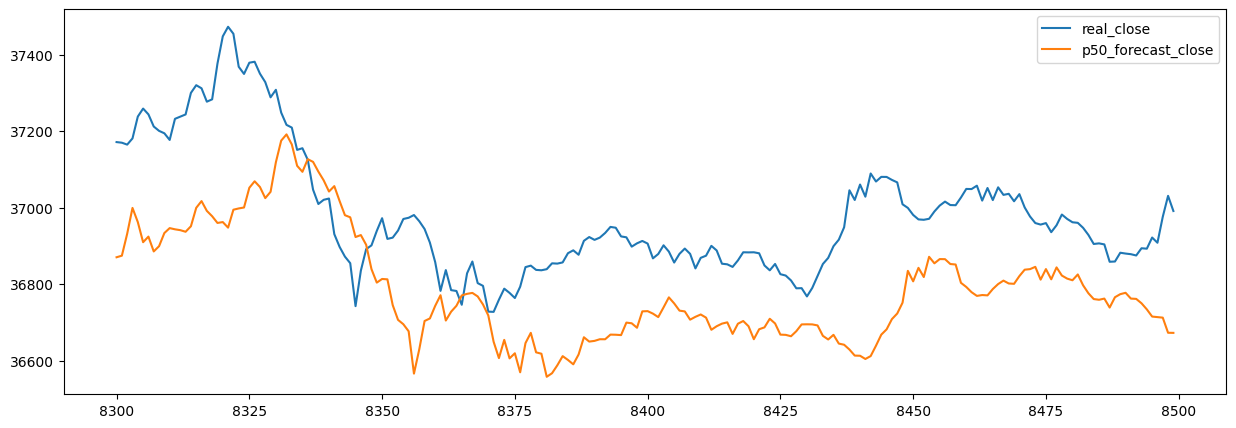

In [6]:
real_and_pred_results[['real_close','p50_forecast_close']][8300:8500].plot(figsize=(15,5))